Jupyter notebook for scrapping data om fbref


In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from io import StringIO
import html5lib
import warnings

Example link:

https://fbref.com/en/comps/Big5/2023-2024/shooting/players/2023-2024-Big-5-European-Leagues-Stats


In [5]:
# For this function, the base code is from claude.ai, but modified to correct bugs
def scrape_fbref_stat(url):
    
    warnings.filterwarnings('ignore', category=UserWarning)
    
    # Send a request to the webpage
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    
    # Parse the HTML
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the table with penalty statistics
    penalty_table = soup.find('table', {'id': 'stats_shooting'})
    
    # Convert to DataFrame, keeping multi-level columns
    df = pd.read_html(str(penalty_table), header=[0, 1])[0]
    
    # Print full column structure to verify
    print("Full Columns:", df.columns.tolist())
    print(df.shape)
    
    # Clean and filter the data
    filt_df = df[[('Unnamed: 1_level_0', 'Player'), ('Standard', 'PK'), ('Standard', 'PKatt')]]
    filt_df = filt_df[filt_df[('Unnamed: 1_level_0', 'Player')].apply(lambda x: isinstance(x, str) and x != 'Player')]
    filt_df[('Standard', 'PK')] = pd.to_numeric(filt_df[('Standard', 'PK')], errors='coerce').fillna(0)
    filt_df[('Standard', 'PKatt')] = pd.to_numeric(filt_df[('Standard', 'PKatt')], errors='coerce').fillna(0)
        
    return filt_df

# Example usage
#url = 'https://fbref.com/en/comps/Big5/2023-2024/shooting/players/2023-2024-Big-5-European-Leagues-Stats'
#penalties_df = scrape_fbref_stat(url)
#print(penalties_df)

In [6]:
seasons = ["2016-2017","2017-2018","2018-2019","2020-2021","2021-2022","2022-2023"]
urls = [fr'https://fbref.com/en/comps/Big5/{season}/shooting/players/{season}-Big-5-European-Leagues-Stats' for season in seasons]

In [7]:
def aggregate_across_seasons(urls):
    all_seasons_penalties = []    
    for url in urls:
        season_df = scrape_fbref_stat(url)
        if season_df is not None:
            all_seasons_penalties.append(season_df)
    
    if not all_seasons_penalties:
        print("No data collected from the provided URLs.")
        return None
    
    combined_df = pd.concat(all_seasons_penalties, ignore_index=True)
    
    # Group by player name and sum their cumulative penalty statistics
    cumulative_df = combined_df.groupby(('Unnamed: 1_level_0', 'Player')).agg({
        ('Standard', 'PK'): 'sum',
        ('Standard', 'PKatt'): 'sum'
    }).reset_index()
    
    return cumulative_df

In [ ]:
seasons_df = aggregate_across_seasons(urls)

In [9]:
seasons_df.shape

(6258, 3)

In [ ]:
# Saving the dataframe to csv.
seasons_df.to_csv("826SR.csv")

## Checkpoint

No need to rerun the above scrapping, loading the csv file is sufficient to plot the following graphs.

In [6]:
df = pd.read_csv("826SR.csv", header=[0,1])

In [7]:
df.columns

MultiIndex([('Unnamed: 0_level_0', 'Unnamed: 0_level_1'),
            ('Unnamed: 1_level_0',             'Player'),
            (          'Standard',                 'PK'),
            (          'Standard',              'PKatt'),
            (       'SuccessRate', 'Unnamed: 4_level_1')],
           )

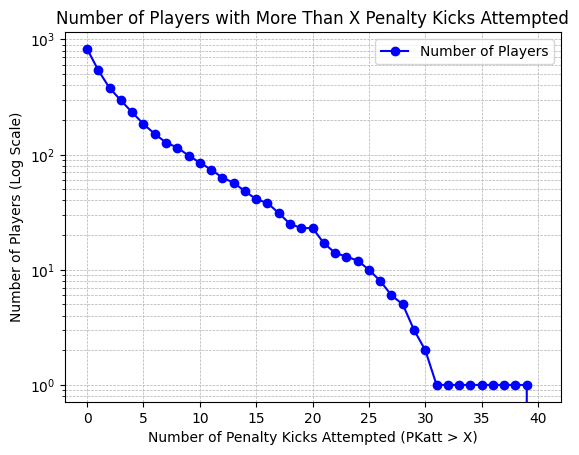

In [8]:
import matplotlib.pyplot as plt 

x_range = range(41)
y_values = [sum(df[('Standard', 'PKatt')] > x) for x in x_range]

plt.plot(x_range, y_values, marker='o', linestyle='-', color='b', label='Number of Players')
plt.yscale('log')
# Adding labels and title
plt.title('Number of Players with More Than X Penalty Kicks Attempted')
plt.xlabel('Number of Penalty Kicks Attempted (PKatt > X)')
plt.ylabel('Number of Players (Log Scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

It is interesting to note that the number of data points decreases logarithmicly with the minimum number of penalty kick attempted.

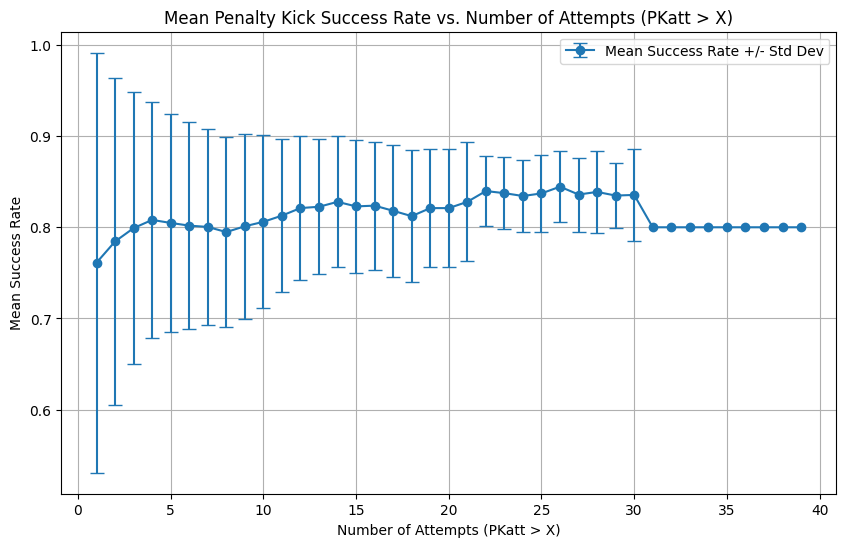

In [9]:
df['SuccessRate'] = df[('Standard', 'PK')] / df[('Standard', 'PKatt')]

# Prepare for the x values (thresholds) and y values (mean success rate and std dev)
X_vals = range(1,40)
mean_rates = []
std_devs = []

for X in X_vals:
    filtered_df = df[df[('Standard', 'PKatt')] > X]
    if len(filtered_df) > 0:  # Only calculate if there are players left
        mean_rate = filtered_df['SuccessRate'].mean()
        std_dev = filtered_df['SuccessRate'].std()
    else:
        mean_rate = None
        std_dev = None
    
    mean_rates.extend(mean_rate.tolist())
    std_devs.extend(std_dev.tolist())

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(X_vals, mean_rates, yerr=std_devs, fmt='-o', capsize=5, label='Mean Success Rate +/- Std Dev')
plt.title('Mean Penalty Kick Success Rate vs. Number of Attempts (PKatt > X)')
plt.xlabel('Number of Attempts (PKatt > X)')
plt.ylabel('Mean Success Rate')
plt.grid(True)
plt.legend()
plt.show()